In [1]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
import mmcv
from mmtrack.apis import inference_mot, init_model as init_tracking_model
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info_new'
os.makedirs(emb_analysis_session_data,exist_ok=True)

embmatched_id_raw_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/embmatched_id_raw'
os.makedirs(embmatched_id_raw_data_dir,exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)

cross_session_input_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/cross_session_input'
os.makedirs(cross_session_input_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/session_matching_info'
os.makedirs(id_viz_cache_root, exist_ok=True)

/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Get frame file data for all sessions

In [2]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

In [3]:
session_filter_list = ['classinsight-cmu_05681A_ghc_4301_201905011630',
 'classinsight-cmu_05681A_ghc_4301_201904171630',
 'classinsight-cmu_05681A_ghc_4301_201902201630',
 'classinsight-cmu_05681A_ghc_4301_201904101630',
 'classinsight-cmu_05681A_ghc_4301_201901231630',
                       
 'classinsight-cmu_05418A_ghc_4102_201902251200',
 'classinsight-cmu_05418A_ghc_4102_201904081200',
 'classinsight-cmu_05418A_ghc_4102_201905011200',
 'classinsight-cmu_05418A_ghc_4102_201904291200',
 'classinsight-cmu_05418A_ghc_4102_201904011200',
                       
 'classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
                       
 'classinsight-cmu_21127J_ghc_4102_201904230930',
 'classinsight-cmu_21127J_ghc_4102_201903260930',
 'classinsight-cmu_21127J_ghc_4102_201904160930',
 'classinsight-cmu_21127J_ghc_4102_201904300930',
 'classinsight-cmu_21127J_ghc_4102_201903190930',
                       
 'classinsight-cmu_05410A_ghc_4301_201904151500',
 'classinsight-cmu_05410A_ghc_4301_201902251500',
 'classinsight-cmu_05410A_ghc_4301_201904081500',
 'classinsight-cmu_05410A_ghc_4301_201904221500',
 'classinsight-cmu_05410A_ghc_4301_201902181500',
                       
 'classinsight-cmu_17214B_ph_a21_201902271030',
 'classinsight-cmu_17214B_ph_a21_201903061030',
 'classinsight-cmu_17214B_ph_a21_201904031030',
 'classinsight-cmu_17214B_ph_a21_201904101030',
 'classinsight-cmu_17214B_ph_a21_201904241030',
                       
 'classinsight-cmu_17214C_ph_225b_201904031130',
 'classinsight-cmu_17214C_ph_225b_201904101130',
 'classinsight-cmu_17214C_ph_225b_201904171130',
 'classinsight-cmu_17214C_ph_225b_201904241130',
 'classinsight-cmu_17214C_ph_225b_201905011130',
                       
 'classinsight-cmu_05410B_ghc_4211_201902111500',
 'classinsight-cmu_05410B_ghc_4211_201903181500',
 'classinsight-cmu_05410B_ghc_4211_201904081500',
 'classinsight-cmu_05410B_ghc_4211_201904151500',
 'classinsight-cmu_05410B_ghc_4211_201904221500',
 'classinsight-cmu_05410B_ghc_4211_201901281500'
]

# Get vizualization for single session

In [4]:
sample_course = '05410B'
sample_session_id = 'classinsight-cmu_05410B_ghc_4211_201904221500-front'
session_tracking_cache_file = f"{track_analysis_session_data}/{sample_session_id}.pb"
session_preprocessed_id_map_file = f"{postprocessed_id_map_data_dir}/{sample_session_id}.pb"
session_frame_dir = f'{base_dir}/{sample_course}/{sample_session_id}'
session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sample_session_id.split("-front")[0]}/{sample_session_id}.avi'
session_frame_dir

'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face//05410B/classinsight-cmu_05410B_ghc_4211_201904221500-front'

In [5]:
old_to_new_id_map = pickle.load(open(session_preprocessed_id_map_file,"rb"))
df_session_eligible_pairs = pd.read_csv(f"{embmatched_id_map_data_dir}/{sample_session_id}.csv")
# Correct new ids with dict from eligible pairs
eligible_id_map_dict = {}
for id_pair in df_session_eligible_pairs.id_pair.values:
    (id1, id2) = eval(id_pair)
    print(id1, id2)
    if id2 in eligible_id_map_dict:
        eligible_id_map_dict[id1] = eligible_id_map_dict[id2]
    else:
        eligible_id_map_dict[id2] = id1

sprint(eligible_id_map_dict)

# correct created eligible map for once more
for key in sorted(list(eligible_id_map_dict.keys())):
    key_value = eligible_id_map_dict[key]
    if key_value in eligible_id_map_dict.keys():
        eligible_id_map_dict[key] = eligible_id_map_dict[key_value]
sprint(eligible_id_map_dict) 
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 
sprint("replacing ids in old to new id maps")
for old_id in old_to_new_id_map:
    if old_to_new_id_map[old_id] in eligible_id_map_dict:
        print(f"replacing {old_id}:{old_to_new_id_map[old_id]} -->{eligible_id_map_dict[old_to_new_id_map[old_id]]}")
        old_to_new_id_map[old_id] = eligible_id_map_dict[old_to_new_id_map[old_id]]
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 


1 26
1 37
22 29
23 37
25 47
25 31
35 49
38 47
38 45
39 47
Dict: eligible_id_map_dict
Key: Value


{23: 1, 26: 1, 29: 22, 31: 25, 37: 1, 38: 25, 39: 25, 45: 38, 47: 25, 49: 35}

Dict: eligible_id_map_dict
Key: Value


{23: 1, 26: 1, 29: 22, 31: 25, 37: 1, 38: 25, 39: 25, 45: 25, 47: 25, 49: 35}

"replacing ids in old to new id maps" : replacing ids in old to new id maps
replacing 304:23 -->1
replacing 324:26 -->1
replacing 436:29 -->22
replacing 503:31 -->25
replacing 778:37 -->1
replacing 818:38 -->25
replacing 891:39 -->25
replacing 1064:45 -->25
replacing 1095:47 -->25
replacing 1201:49 -->35
replacing 555:26 -->1
replacing 651:29 -->22
replacing 693:26 -->1
replacing 1129:47 -->25


In [6]:
# map processed ids to tracking df
df_tracking_new = pickle.load(open(session_tracking_cache_file,"rb")).transpose()
total_idxs = df_tracking_new.index.max()
for old_id in old_to_new_id_map:
    new_id = old_to_new_id_map[old_id]
    if not new_id==10000:
        new_id_col = f'N{new_id}'
        if new_id_col not in df_tracking_new:
            df_tracking_new[new_id_col] = None
        df_tracking_new[new_id_col] =  df_tracking_new[old_id].where(~df_tracking_new[old_id].isnull(), df_tracking_new[old_id])
    df_tracking_new = df_tracking_new.drop(old_id, axis=1)




In [7]:
col_start_stop_idxs = []
for col in df_tracking_new.columns:
    one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
df_id_start_stop['id'] = df_id_start_stop['id'].apply(lambda x: int(x[1:]))
df_id_start_stop

,id,min_idx,max_idx,total_idxs
0,0,0,3147,3147
1,1,49194,71979,22785
2,2,66237,71979,5742
3,3,0,2373,2373
4,4,0,3117,3117
5,5,55482,57633,2151
6,6,0,71979,71979
7,7,51498,54756,3258
8,8,0,1701,1701
9,9,0,48885,48885


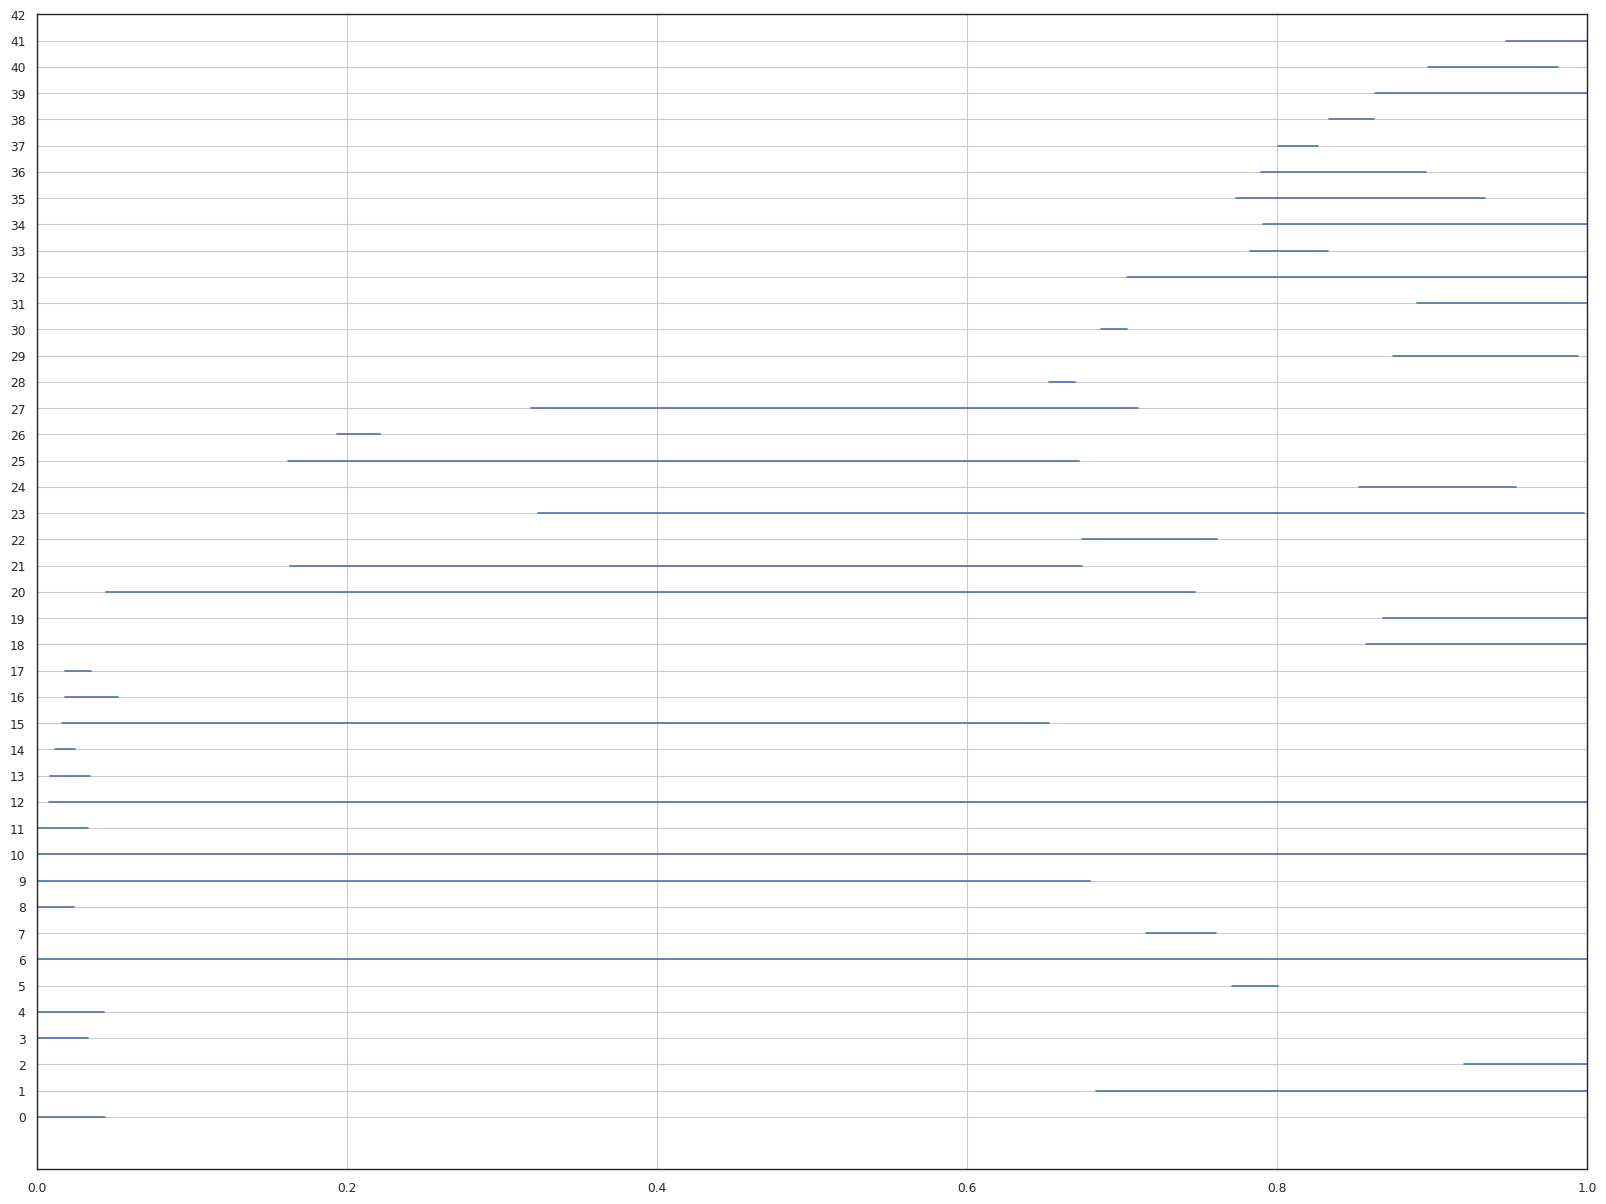

In [8]:
_ = plt.figure(figsize=(20,15))
for row_idx, row in df_id_start_stop.iterrows():
    plt.axhline(y=row_idx, xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs)
plt.yticks(range(df_id_start_stop.shape[0]), range(df_id_start_stop.shape[0]))
plt.grid() 

In [9]:
session_frames = df_tracking_new.index.values.tolist()
session_ids_covered = []
selected_frames = []
segments = []
segment_half_size = 50
for row_idx, row in df_id_start_stop.sort_values(by='total_idxs').iterrows():
    id_start, id_stop = row['min_idx'],row['max_idx']
    seg_mid = (id_start+id_stop)/2
    seg_start, seg_end = max(seg_mid-segment_half_size, 0), min(seg_mid+segment_half_size, total_idxs)
    is_id_covered = df_id_start_stop.apply(lambda row: (seg_end<=row['max_idx']) & (seg_start>=row['min_idx']),axis=1)
    seg_ids_covered = df_id_start_stop[is_id_covered]['id']
    new_ids_covered = [xr for xr in seg_ids_covered if xr not in session_ids_covered]
    if len(new_ids_covered)>0:        
        segment_frames = [xr for xr in session_frames if ((xr>=seg_start) and (xr<=seg_end))]
        selected_frames+=segment_frames
        segments.append((seg_start, seg_end, new_ids_covered, segment_frames))
        session_ids_covered+=new_ids_covered

sprint(segments)
    
    


List: segments


[
    (
        1246.0,
        1346.0,
        [0, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15],
        [
            1248,
            1251,
            1254,
            1257,
            1260,
            1263,
            1266,
            1269,
            1272,
            1275,
            1278,
            1281,
            1284,
            1287,
            1290,
            1293,
            1296,
            1299,
            1302,
            1305,
            1308,
            1311,
            1314,
            1317,
            1320,
            1323,
            1326,
            1329,
            1332,
            1335,
            1338,
            1341,
            1344
        ]
    ),
    (
        69319.0,
        69419.0,
        [1, 2, 18, 19, 24, 33, 35, 36, 41, 48, 50, 51, 52],
        [
            69321,
            69324,
            69327,
            69330,
            69333,
            69336,
            69339,
            69342,
            69345,
            69348,
            69351,
            69354,
            69357,
            69360,
            69363,
            69366,
            69369,
            69372,
            69375,
            69378,
            69381,
            69384,
            69387,
            69390,
            69393,
            69396,
            69399,
            69402,
            69405,
            69408,
            69411,
            69414,
            69417
        ]
    ),
    (
        49952.5,
        50052.5,
        [20, 22, 30, 34],
        [
            49953,
            49956,
            49959,
            49962,
            49965,
            49968,
            49971,
            49974,
            49977,
            49980,
            49983,
            49986,
            49989,
            49992,
            49995,
            49998,
            50001,
            50004,
            50007,
            50010,
            50013,
            50016,
            50019,
            50022,
            50025,
            50028,
            50031,
            50034,
            50037,
            50040,
            50043,
            50046,
            50049,
            50052
        ]
    ),
    (
        47539.0,
        47639.0,
        [21, 27, 32],
        [
            47541,
            47544,
            47547,
            47550,
            47553,
            47556,
            47559,
            47562,
            47565,
            47568,
            47571,
            47574,
            47577,
            47580,
            47583,
            47586,
            47589,
            47592,
            47595,
            47598,
            47601,
            47604,
            47607,
            47610,
            47613,
            47616,
            47619,
            47622,
            47625,
            47628,
            47631,
            47634,
            47637
        ]
    ),
    (
        1846.0,
        1946.0,
        [16, 17],
        [
            1848,
            1851,
            1854,
            1857,
            1860,
            1863,
            1866,
            1869,
            1872,
            1875,
            1878,
            1881,
            1884,
            1887,
            1890,
            1893,
            1896,
            1899,
            1902,
            1905,
            1908,
            1911,
            1914,
            1917,
            1920,
            1923,
            1926,
            1929,
            1932,
            1935,
            1938,
            1941,
            1944
        ]
    ),
    (
        58492.0,
        58592.0,
        [40, 42, 43, 44],
        [
            58494,
            58497,
            58500,
            58503,
            58506,
            58509,
            58512,
            58515,
            58518,
            58521,
            58524,
            58527,
            58530,
            58533,
            58536,
            58539,
            58542,
       

In [10]:
SOURCE_ROOT = '/home/prasoon/video_analysis/edusenseV2compute/compute/videoV3'
run_config = {
    'track_config':f'{SOURCE_ROOT}/configs/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half.py',
    'track_checkpoint':f'{SOURCE_ROOT}/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth',
    'device':'cuda:1',
}


In [11]:
# for given frame ranges get video frames and tracking results
all_frames = mmcv.VideoReader(session_video_file)

required_frame_ids = np.unique(sorted(selected_frames))
frame_data_dict = {}

for frame_idx, frame_img in enumerate(all_frames):
    if (frame_idx in required_frame_ids) & (frame_idx%3==0):
        frame_data_dict[frame_idx] = frame_img
    if frame_idx%10000==0:
        print(f"Looped {frame_idx} images")

[h264 @ 0x9ccc8c0] error while decoding MB 130 5, bytestream -13
[h264 @ 0x9ccc8c0] cabac decode of qscale diff failed at 8 75
[h264 @ 0x9ccc8c0] error while decoding MB 8 75, bytestream -9
[h264 @ 0x9ccc8c0] error while decoding MB 141 98, bytestream -7
[h264 @ 0x9458540] error while decoding MB 130 5, bytestream -13
[h264 @ 0x9439dc0] cabac decode of qscale diff failed at 8 75
[h264 @ 0x9439dc0] error while decoding MB 8 75, bytestream -9
[h264 @ 0xcc861c0] error while decoding MB 141 98, bytestream -7
[h264 @ 0xcef3600] error while decoding MB 117 73, bytestream -7
[h264 @ 0x9458540] error while decoding MB 130 5, bytestream -13
[h264 @ 0x9439dc0] cabac decode of qscale diff failed at 8 75
[h264 @ 0x9439dc0] error while decoding MB 8 75, bytestream -9
[h264 @ 0xcc861c0] error while decoding MB 141 98, bytestream -7
[h264 @ 0xcef3600] error while decoding MB 117 73, bytestream -7


Looped 0 images


[h264 @ 0xd22ff00] error while decoding MB 96 107, bytestream -7
[h264 @ 0xd091a80] error while decoding MB 206 126, bytestream -9
[h264 @ 0xd22ff00] error while decoding MB 25 79, bytestream -5
[h264 @ 0xd3ce500] error while decoding MB 145 71, bytestream -9
[h264 @ 0xd091a80] error while decoding MB 89 78, bytestream -11
[h264 @ 0xd22ff00] error while decoding MB 212 87, bytestream -9
[h264 @ 0xd3ce500] error while decoding MB 50 117, bytestream -5
[h264 @ 0x9cd3240] error while decoding MB 41 91, bytestream -5
[h264 @ 0xcc861c0] error while decoding MB 129 114, bytestream -26
[h264 @ 0xce243c0] error while decoding MB 140 115, bytestream -22
[h264 @ 0xcfc2840] error while decoding MB 127 106, bytestream -24
[h264 @ 0xd160cc0] error while decoding MB 237 117, bytestream -10
[h264 @ 0xd2ff140] error while decoding MB 135 94, bytestream -22
[h264 @ 0xd49d8c0] error while decoding MB 12 95, bytestream -9
[h264 @ 0xd739800] error while decoding MB 105 106, bytestream -5
[h264 @ 0x9439dc0

Looped 10000 images


[h264 @ 0xce243c0] error while decoding MB 98 105, bytestream -12
[h264 @ 0xcfc2840] error while decoding MB 218 94, bytestream -10
[h264 @ 0xd160cc0] error while decoding MB 121 106, bytestream -18
[h264 @ 0xd2ff140] error while decoding MB 167 87, bytestream -21
[h264 @ 0xd49d8c0] error while decoding MB 167 98, bytestream -26
[h264 @ 0xd739800] error while decoding MB 18 93, bytestream -18
[h264 @ 0x9439dc0] error while decoding MB 132 117, bytestream -32
[h264 @ 0xcc861c0] error while decoding MB 94 108, bytestream -5
[h264 @ 0xce243c0] error while decoding MB 102 103, bytestream -37
[h264 @ 0xcfc2840] error while decoding MB 80 94, bytestream -8
[h264 @ 0xd160cc0] error while decoding MB 234 69, bytestream -12
[h264 @ 0xd2ff140] error while decoding MB 163 76, bytestream -18
[h264 @ 0xd49d8c0] error while decoding MB 59 63, bytestream -24
[h264 @ 0xd739800] error while decoding MB 122 85, bytestream -22
[h264 @ 0x9439dc0] error while decoding MB 104 104, bytestream -12
[h264 @ 0xc

Looped 20000 images


[h264 @ 0x9439dc0] error while decoding MB 224 96, bytestream -28
[h264 @ 0xcc861c0] error while decoding MB 199 32, bytestream -7
[h264 @ 0xce243c0] error while decoding MB 101 92, bytestream -24
[h264 @ 0xcfc2840] error while decoding MB 17 85, bytestream -12
[h264 @ 0xd160cc0] error while decoding MB 121 65, bytestream -10
[h264 @ 0xd2ff140] error while decoding MB 114 70, bytestream -18
[h264 @ 0xd49d8c0] error while decoding MB 233 84, bytestream -28
[h264 @ 0xd739800] error while decoding MB 10 87, bytestream -16
[h264 @ 0x9439dc0] error while decoding MB 214 54, bytestream -14
[h264 @ 0xcc861c0] error while decoding MB 235 82, bytestream -26
[h264 @ 0xce243c0] error while decoding MB 79 95, bytestream -6
[h264 @ 0xcfc2840] error while decoding MB 69 85, bytestream -6
[h264 @ 0xd160cc0] error while decoding MB 33 71, bytestream -25
[h264 @ 0xd2ff140] error while decoding MB 207 55, bytestream -12
[h264 @ 0xd49d8c0] error while decoding MB 122 81, bytestream -6
[h264 @ 0xd739800] 

Looped 30000 images


[h264 @ 0xd49d8c0] error while decoding MB 163 65, bytestream -24
[h264 @ 0xd739800] error while decoding MB 8 50, bytestream -6
[h264 @ 0x9439dc0] error while decoding MB 30 62, bytestream -14
[h264 @ 0xcc861c0] error while decoding MB 40 55, bytestream -24
[h264 @ 0xce243c0] error while decoding MB 47 57, bytestream -31
[h264 @ 0xcfc2840] error while decoding MB 74 16, bytestream -14
[h264 @ 0xd160cc0] error while decoding MB 120 19, bytestream -16
[h264 @ 0xd2ff140] error while decoding MB 199 8, bytestream -52
[h264 @ 0xd49d8c0] error while decoding MB 46 7, bytestream -12
[h264 @ 0xd739800] error while decoding MB 117 118, bytestream -16
[h264 @ 0x9439dc0] error while decoding MB 225 116, bytestream -40
[h264 @ 0xcc861c0] error while decoding MB 85 116, bytestream -14
[h264 @ 0xce243c0] error while decoding MB 167 126, bytestream -18
[h264 @ 0xcfc2840] error while decoding MB 139 117, bytestream -8
[h264 @ 0xd160cc0] error while decoding MB 135 106, bytestream -14
[h264 @ 0xd2ff14

Looped 40000 images


[h264 @ 0xd160cc0] error while decoding MB 148 95, bytestream -10
[h264 @ 0xd2ff140] error while decoding MB 156 94, bytestream -8
[h264 @ 0xd49d8c0] error while decoding MB 147 107, bytestream -10
[h264 @ 0xd739800] error while decoding MB 91 105, bytestream -18
[h264 @ 0x9439dc0] error while decoding MB 10 112, bytestream -24
[h264 @ 0xcc861c0] error while decoding MB 219 102, bytestream -12
[h264 @ 0xce243c0] error while decoding MB 228 115, bytestream -30
[h264 @ 0xcfc2840] error while decoding MB 8 106, bytestream -10
[h264 @ 0xd160cc0] error while decoding MB 222 93, bytestream -12
[h264 @ 0xd2ff140] error while decoding MB 124 91, bytestream -28
[h264 @ 0xd49d8c0] error while decoding MB 141 105, bytestream -16
[h264 @ 0xd739800] error while decoding MB 106 105, bytestream -32
[h264 @ 0x9439dc0] error while decoding MB 116 108, bytestream -7
[h264 @ 0xcc861c0] error while decoding MB 215 87, bytestream -7
[h264 @ 0xce243c0] error while decoding MB 121 101, bytestream -32
[h264 @

Looped 50000 images


[h264 @ 0xcfc2840] error while decoding MB 128 106, bytestream -29
[h264 @ 0xd160cc0] error while decoding MB 115 85, bytestream -18
[h264 @ 0xd2ff140] error while decoding MB 129 48, bytestream -20
[h264 @ 0xd49d8c0] error while decoding MB 84 93, bytestream -5
[h264 @ 0xd739800] error while decoding MB 43 94, bytestream -6
[h264 @ 0x9439dc0] error while decoding MB 225 81, bytestream -36
[h264 @ 0xcc861c0] error while decoding MB 238 84, bytestream -10
[h264 @ 0xce243c0] error while decoding MB 79 99, bytestream -6
[h264 @ 0xcfc2840] error while decoding MB 208 88, bytestream -8
[h264 @ 0xd160cc0] error while decoding MB 34 77, bytestream -24
[h264 @ 0xd2ff140] error while decoding MB 225 81, bytestream -32
[h264 @ 0xd49d8c0] error while decoding MB 125 94, bytestream -15
[h264 @ 0xd739800] error while decoding MB 113 87, bytestream -40
[h264 @ 0x9439dc0] error while decoding MB 234 50, bytestream -22
[h264 @ 0xcc861c0] error while decoding MB 139 89, bytestream -19
[h264 @ 0xce243c0

Looped 60000 images


[h264 @ 0xcc861c0] error while decoding MB 93 68, bytestream -10
[h264 @ 0xce243c0] error while decoding MB 201 16, bytestream -14
[h264 @ 0xcfc2840] error while decoding MB 193 37, bytestream -8
[h264 @ 0xd160cc0] error while decoding MB 132 14, bytestream -6
[h264 @ 0xd2ff140] error while decoding MB 127 55, bytestream -20
[h264 @ 0xd49d8c0] error while decoding MB 36 53, bytestream -32
[h264 @ 0xd739800] error while decoding MB 128 34, bytestream -12
[h264 @ 0x9439dc0] error while decoding MB 167 11, bytestream -8
[h264 @ 0xcc861c0] error while decoding MB 225 115, bytestream -28
[h264 @ 0xce243c0] error while decoding MB 224 122, bytestream -10
[h264 @ 0xcfc2840] error while decoding MB 228 114, bytestream -12
[h264 @ 0xd160cc0] error while decoding MB 133 5, bytestream -14
[h264 @ 0xd2ff140] error while decoding MB 128 113, bytestream -14
[h264 @ 0xd49d8c0] error while decoding MB 118 116, bytestream -26
[h264 @ 0xd739800] error while decoding MB 130 123, bytestream -18
[h264 @ 0x

Looped 70000 images


[h264 @ 0xd739800] error while decoding MB 135 103, bytestream -20
[h264 @ 0x9439dc0] error while decoding MB 94 109, bytestream -8
[h264 @ 0xcc861c0] error while decoding MB 90 103, bytestream -8
[h264 @ 0xce243c0] error while decoding MB 214 109, bytestream -9


In [12]:
session_id_viz_dir = f'{id_viz_cache_root}/{sample_session_id}'
os.makedirs(session_id_viz_dir, exist_ok=True)
tracking_model =None
if tracking_model:
    printm("# Deleting Previous Model")
    del tracking_model
tracking_model = init_tracking_model(run_config['track_config'],
                                 run_config['track_checkpoint'],
                                 device=run_config['device'])
for seg_idx, (seg_start, seg_end, new_ids_covered, segment_frames) in enumerate(segments):
    seg_video_id = f'S{seg_idx}_{int(seg_start)}_{int(seg_end)}_{"_".join(map(str,new_ids_covered))}'
    match_cache_dir = f'{session_id_viz_dir}/{seg_video_id}'
    match_video_file = f'{session_id_viz_dir}/{seg_video_id}.mp4'
    if os.path.exists(match_video_file):
        continue
    print(match_video_file)
    os.makedirs(match_cache_dir, exist_ok=True)
    frame_num=0

    for frame_idx in segment_frames:
        frame_tracking_file = f"{session_frame_dir}/{frame_idx}.pb"
        if os.path.exists(frame_tracking_file) and (frame_idx in frame_data_dict):
            frame_file_out = os.path.join(match_cache_dir, f'{frame_num:06d}.jpg')
            frame_num+=1
            if os.path.exists(frame_file_out):
                continue
            frame_tracking_results = pickle.load(open(frame_tracking_file,"rb"))[1]
            for person_idx in range(len(frame_tracking_results)):
                old_id= int(frame_tracking_results[person_idx]['track_id'])
                frame_tracking_results[person_idx]['track_id'] =old_to_new_id_map[old_id]
            frame_img = deepcopy(frame_data_dict[frame_idx])
            if len(frame_tracking_results)>0:
                frame_tracking_results = {
                    'track_bboxes':[np.array([[xr['track_id']]+xr['bbox'].tolist() for xr in frame_tracking_results])],
                    'det_bboxes':[np.array([xr['bbox'].tolist() for xr in frame_tracking_results])]}
                frame_track_img = tracking_model.show_result(
                    frame_img,
                    frame_tracking_results,
                    thickness=5,
                    font_scale=.5,
                    score_thr=0.1,
                    show=False,
                    wait_time=int(1000. / 5),
                    out_file=frame_file_out,
                    backend='cv2')
            else:
                cv2.imwrite(frame_file_out,frame_img)
    
    #         break
    # break
    mmcv.frames2video(match_cache_dir, match_video_file, fps=5, fourcc='mp4v')
    print(f"Done for segment {seg_video_id}")
    # break
    
    

2023-09-03 21:34:44,114 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2023-09-03 21:34:44,735 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2023-09-03 21:34:44,737 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-09-03 21:34:44,739 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-09-03 21:34:47,283 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 320, 1, 

load checkpoint from local path: /home/prasoon/video_analysis/edusenseV2compute/compute/videoV3/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector